In [6]:
#These are all the Important libraries that we need to import
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import crepe
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import pandas as pd
import plotly.graph_objects as go
import IPython.display as ipd
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding
from scipy.signal import find_peaks as scipy_find_peaks
import os

In [19]:
import os
import pandas as pd
import librosa
import crepe
from scipy.interpolate import interp1d

# === SETTINGS ===
vocal_folder = "Vocals_file//Mayamalavagowlai"  # Your folder with WAV files
output_csv = "Master_Crepe_Mayamalavagowlai.csv"
log_csv = "Crepe_logMayamalavagowlai.csv"

# === ENSURE LOG FILE EXISTS AND HAS HEADER ===
if not os.path.exists(log_csv) or os.path.getsize(log_csv) == 0:
    # Create it with correct header
    with open(log_csv, "w") as f:
        f.write("AudioPath\n")
    processed_files = set()
else:
    processed_files = set(pd.read_csv(log_csv)["AudioPath"].values)

# === ENSURE MASTER CSV EXISTS AND HAS HEADER ===
if not os.path.exists(output_csv) or os.path.getsize(output_csv) == 0:
    with open(output_csv, "w") as f:
        f.write("Index,AudioPath,Raaga,SongName,Tonic,Time,Frequency,Confidence\n")
    current_song_index = 1 # Initialize for the first song
else:
    df_existing = pd.read_csv(output_csv)
    # Get the max song index if the file is not empty and has an 'Index' column
    if not df_existing.empty and 'Index' in df_existing.columns:
        current_song_index = df_existing["Index"].max() + 1
    else:
        current_song_index = 1 # Start from 1 if no existing data or 'Index' column

new_log_entries = []

# === PROCESS WAV FILES ===
for filename in os.listdir(vocal_folder):
    if not filename.lower().endswith(".wav"):
        continue

    audio_path = os.path.join(vocal_folder, filename)

    if audio_path in processed_files:
        print(f"🟡 Skipping already processed file: {filename}")
        continue

    print(f"🔧 Processing new file: {filename}")

    # ✅ Extract Raaga, SongName, Tonic
    name_without_ext = filename.replace(".wav", "")
    parts = name_without_ext.split("_")

    if len(parts) >= 3:
        raaga = parts[0]
        songname = "_".join(parts[1:-1])
        tonic = parts[-1]
    else:
        raise ValueError(f"Filename not in expected format: {filename}")

    # === Load audio ===
    y, sr = librosa.load(audio_path, sr=44100)

    # === CREPE pitch estimation ===
    time, frequency, confidence, _ = crepe.predict(y, sr, viterbi=True, step_size=20, model_capacity="tiny")

    # === Interpolate to STFT time grid ===
    spec_time = librosa.times_like(librosa.stft(y), sr=sr)
    interp_freq = interp1d(time, frequency, kind='linear', fill_value='extrapolate')
    interp_conf = interp1d(time, confidence, kind='linear', fill_value='extrapolate')

    new_frequency = interp_freq(spec_time)
    new_confidence = interp_conf(spec_time)

    # ✅ Remove silent parts by confidence threshold
    mask = new_confidence > 0.7  # Adjust threshold as needed
    spec_time = spec_time[mask]
    new_frequency = new_frequency[mask]
    new_confidence = new_confidence[mask]

    # === Assign the same song index to all rows of the current song ===
    df_single = pd.DataFrame({
        "Index": [current_song_index]*len(spec_time), # This is the key change
        "AudioPath": [audio_path]*len(spec_time),
        "Raaga": [raaga]*len(spec_time),
        "SongName": [songname]*len(spec_time),
        "Tonic": [tonic]*len(spec_time),
        "Time": spec_time,
        "Frequency": new_frequency,
        "Confidence": new_confidence
    })

    df_single.to_csv(output_csv, mode='a', index=False, header=False)
    new_log_entries.append(audio_path)
    current_song_index += 1 # Increment for the next song
    print(f"✅ Done with: {filename}")

# === UPDATE LOG ===
if new_log_entries:
    log_df = pd.DataFrame({"AudioPath": new_log_entries})
    log_df.to_csv(log_csv, mode='a', index=False, header=False)

print("🎉 All new files processed and saved.")

🔧 Processing new file: Mayamalavagowlai_DevadevaKalayami01__G#3.wav
558/558 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step
✅ Done with: Mayamalavagowlai_DevadevaKalayami01__G#3.wav
🔧 Processing new file: Mayamalavagowlai_Inthaparaka01__C4.wav
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step
✅ Done with: Mayamalavagowlai_Inthaparaka01__C4.wav
🔧 Processing new file: Mayamalavagowlai_MeruSamana01__C4.wav
641/641 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step
✅ Done with: Mayamalavagowlai_MeruSamana01__C4.wav
🎉 All new files processed and saved.


In [20]:
def plot_spectrogram_with_crepe(spec_time, conf, S_db, sr):
    plt.figure(figsize=(14, 8))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='viridis')
    plt.plot(spec_time, conf, color='r', linewidth=1.5, label='CREPE Pitch')  # Use spec_time
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 2000)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def find_tonic(S, sr):
    chroma = librosa.feature.chroma_stft(S=np.abs(S), sr=sr)
    pitch_class_sums = np.sum(np.abs(chroma), axis=1)
    pitch_labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    pitch_class_dict = dict(zip(pitch_labels, pitch_class_sums))
    return max(pitch_class_dict, key=pitch_class_dict.get)

def get_carnatic_frequencies(tonic):
    # Intonational ratios for the basic set of Carnatic notes
    carnatic_ratios = {
        'sa': 0.5*1.0,    # Tonic (Sa)
        'ri1': 0.5*16/15, # Ri1
        'ri2': 0.5*9/8,  # Ri2
        'ga1': 0.5*6/5,  # Ga1
        'ga2': 0.5*5/4, # Ga2
        'ma1': 0.5*4/3, # Ma1
        'ma2': 0.5*45/32,   # Ma2
        'pa': 0.5*3/2,    # Pa
        'da1': 0.5*8/5, # Dha1
        'da2': 0.5*5/3, # Dha2
        'ni1': 0.5*16/9, # Ni1
        'ni2': 0.5*15/8,   # Ni2

        'Sa': 1.0,    # Tonic (Sa)
        'Ri1': 16/15, # Ri1
        'Ri2': 9/8,  # Ri2
        'Ga1': 6/5,  # Ga1
        'Ga2': 5/4, # Ga2
        'Ma1': 4/3, # Ma1
        'Ma2': 45/32,   # Ma2
        'Pa': 3/2,    # Pa
        'Da1': 8/5, # Dha1
        'Da2': 5/3, # Dha2
        'Ni1': 16/9, # Ni1
        'Ni2': 15/8,   # Ni2

        'SA': 2.0,   # Octave higher (Sa)
        'RI1': 2*16/15, # Ri1
        'RI2': 2*9/8,  # Ri2
        'GA1': 2*6/5,  # Ga1
        'GA2': 2*5/4, # Ga2
        'MA1': 2*4/3, # Ma1
        'MA2': 2*45/32,   # Ma2
        'PA': 2*3/2,    # Pa
        'DA1': 2*8/5, # Dha1
        'DA2': 2*5/3, # Dha2
        'NI1': 2*16/9, # Ni1
        'NI2': 2*15/8,   
    }

    tonic_freq = librosa.note_to_hz(tonic)  # Get the frequency of the tonic

    # Calculate the frequencies for each Carnatic note relative to the tonic
    carnatic_frequencies = {note: tonic_freq * ratio for note, ratio in carnatic_ratios.items()}
    return carnatic_frequencies

def get_closest_note(freq, carnatic_frequencies):
    """Find the closest Carnatic note for a given frequency."""
    return min(carnatic_frequencies, key=lambda note: abs(carnatic_frequencies[note] - freq))

def get_closest_frequency(freq, carnatic_frequencies):
    """Find the closest Carnatic note frequency for a given frequency."""
    return min(carnatic_frequencies.values(), key=lambda f: abs(f - freq))

def get_index_from_time(time_input,conf):
    # Define the start and end times
    total_duration = end_time - start_time
    num_pieces = len(conf)
    
    # Calculate the duration of each piece
    duration_per_piece = total_duration / num_pieces
    
    # Check if the input time is within the valid range
    if time_input < start_time or time_input > end_time:
        raise ValueError(f"Input time must be between {start_time} and {end_time} seconds.")
    
    # Calculate the index
    index = int((time_input - start_time) / duration_per_piece)
    
    return index

def plot_frequency_with_carnatic_notes(frequency_list, beat_frames, tonic,beat_sr):
    beat_frames= librosa.frames_to_time(beat_frames, sr=beat_sr)
    loc_extremes = np.where(np.diff(np.sign(np.diff(frequency_list, prepend=np.nan, append=np.nan))) != 0)[0]
    extremes = frequency_list[loc_extremes].tolist()
    angles = np.degrees(np.arctan(np.diff(frequency_list, prepend=np.nan, append=np.nan) / 2))
    # notelist = [(conf[i], i, angles[i], angles[i + 1], i in loc_extremes) for i in range(len(conf) - 1)]
    carnatic_frequencies = get_carnatic_frequencies(tonic)
    frequency_array = np.array(frequency_list)
    
    beat_points=[]
    for i in beat_frames:
        if i < start_time or i > end_time:
            continue
        beat_points.append(get_index_from_time(i,frequency_list))




    # Identify valid (non-NaN) frames
    valid_indices = ~np.isnan(frequency_array)  
    valid_frequencies = frequency_array[valid_indices]
    if len(valid_frequencies) == 0:
        raise ValueError("No valid frequencies to process.")

    carnatic_frequencies = get_carnatic_frequencies(tonic)

    # Plot the graph
    fig = go.Figure()

    # Plot the frequency graph with gaps for NaNs
    for start, end in zip(
        np.where(np.diff(np.concatenate(([0], valid_indices, [0]))) == 1)[0],
        np.where(np.diff(np.concatenate(([0], valid_indices, [0]))) == -1)[0]
    ):
        fig.add_trace(go.Scatter(
            x=np.arange(start, end),
            y=frequency_array[start:end],
            mode='lines',
            name='Frequency (Hz)',
            line=dict(color='blue')
        ))

    # Plot horizontal lines for Carnatic notes
    for note, freq in carnatic_frequencies.items():
        fig.add_trace(go.Scatter(
            x=[0, len(frequency_list) - 1],
            y=[freq, freq],
            mode='lines',
            line=dict(dash='dash', color='gray', width=2),
            name=note,
            hovertemplate=f"{note} ({freq:.2f} Hz)"
        ))

    # Plot the extremes as red dots
    fig.add_trace(go.Scatter(
        x=loc_extremes,
        y=extremes,
        mode='markers',
        marker=dict(color='red', size=2, symbol='circle'),
        name='Extremes'
    ))

    # Plot vertical lines for beat points
    for beat in beat_points:
        fig.add_trace(go.Scatter(
            x=[beat, beat],  # Vertical line at 'beat'
            y=[np.nanmin(frequency_array), np.nanmax(frequency_array)],  # Full y-range
            mode='lines',
            line=dict(color='orange', width=2),
            name=f'Beat @ {beat}'
        ))

    fig.update_layout(
        title=f'Frequency with Carnatic Notes (Tonic: {tonic})',
        xaxis_title='Time',
        yaxis_title='Frequency (Hz)',
        showlegend=True
    )

    fig.show()

def breaklist(elements, indexes):
    segmented_lists = []
    start_index = 0  

    for idx in indexes:
        segment = elements[start_index:idx]
        segmented_lists.append(segment)
        start_index = idx  
    if start_index < len(elements):
        segmented_lists.append(elements[start_index:])

    return segmented_lists

def plot_with_carnatic_bars(note_num, noteslist, carnatic_frequencies):
    bars = list(carnatic_frequencies.values())
    
    # Find relevant frequency range
    min_freq = get_closest_frequency(np.nanmin(noteslist[note_num]), carnatic_frequencies)
    max_freq = get_closest_frequency(np.nanmax(noteslist[note_num]), carnatic_frequencies)
    
    # Filter bars within the frequency range
    newbars = [i for i in bars if min_freq <= i <= max_freq]
    
    # Plot
    plt.plot(noteslist[note_num])
    for i in newbars:
        plt.axhline(y=i, color='r', linestyle='--')
    plt.show()
    for i in newbars:
        print(get_closest_note(i, carnatic_frequencies))

def spectral_decomp(note, n_clusters, plot=True):
    note = np.array(note)
    X = np.column_stack((np.arange(len(note)), note))
    embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
    X_transformed = embedding.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_transformed)

    # Sort clusters based on first occurrence
    unique_clusters = np.unique(labels, return_index=True)
    sorted_clusters = [cluster for _, cluster in sorted(zip(unique_clusters[1], unique_clusters[0]))]
    label_mapping = {old: new for new, old in enumerate(sorted_clusters)}
    sorted_labels = np.array([label_mapping[label] for label in labels])

    # Assign frequencies to clusters
    segments = [[] for _ in range(n_clusters)]
    for idx, freq in enumerate(note):
        segments[sorted_labels[idx]].append((idx, freq))

    if plot:
        fig = go.Figure()

        colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
        for i in range(n_clusters):
            indices, freqs = zip(*segments[i]) if segments[i] else ([], [])
            fig.add_trace(go.Scatter(
                x=indices,
                y=freqs,
                mode='markers+lines',
                marker=dict(size=6, color=colors[i % len(colors)]),
            ))

        # Plot horizontal lines at each unique frequency

        unique_freqs = [i for i in get_carnatic_frequencies("C#3").values() if min(note) <= i <= max(note)]
        unique_notes= [i for i in get_carnatic_frequencies("C#3").keys() if min(note) <= get_carnatic_frequencies("C#3")[i] <= max(note)]
        x_values = np.linspace(min(X[:, 0]), max(X[:, 0]), num=100)  # Densely spaced x values

        for i in range (len( unique_freqs)):
            y_values = np.full_like(x_values,unique_freqs[i])
            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                line=dict(color="gray", dash="dash"),
                showlegend=False,
                hovertemplate=f"{unique_notes[i]}({unique_freqs[i]:.2f} Hz)"
            ))

        
        fig.show()

    return [list(zip(*seg))[1] if seg else [] for seg in segments] 

def playnote(n, beat_audio, beat_sr, beat_times, start_time):
    adjusted_beat_times = beat_times - start_time
    adjusted_beat_times = adjusted_beat_times[adjusted_beat_times >= 0]  # Remove negative times
    if n < 0 or n >= len(adjusted_beat_times) - 1:
        print("Invalid note index")
        return
    note_start_time = adjusted_beat_times[n]
    note_end_time = adjusted_beat_times[n+1]
    start_sample = int(note_start_time * beat_sr)
    end_sample = int(note_end_time * beat_sr)

    note_audio = beat_audio[start_sample:end_sample]
    ipd.display(ipd.Audio(note_audio, rate=beat_sr))

def find_peaks_and_valleys(conf):
    peaks = []
    valleys = []
    
    for i in range(1, len(conf) - 1):
        if not np.isnan(conf[i-1]) and not np.isnan(conf[i]) and not np.isnan(conf[i+1]):
            if conf[i] > conf[i-1] and conf[i] > conf[i+1]:
                peaks.append(i)
            elif conf[i] < conf[i-1] and conf[i] < conf[i+1]:
                valleys.append(i)
    
    return peaks, valleys

def play_segment_between_beats(beat_audio, beat_sr, beat_frames, beat_index,offset=0):
    # Ensure the beat_index is valid
    if beat_index < 0 or beat_index >= len(beat_frames) - 1:
        print("Invalid beat index. Please provide a valid index.")
        return

    # Get the start and end frames for the segment
    start_frame = beat_frames[beat_index-offset]
    end_frame = beat_frames[beat_index + 1+offset]

    # Convert frames to time
    start_time = librosa.frames_to_time(start_frame, sr=beat_sr)
    end_time = librosa.frames_to_time(end_frame, sr=beat_sr)

    # Convert time to sample indices
    start_sample = int(start_time * beat_sr)
    end_sample = int(end_time * beat_sr)

    # Slice the audio segment
    audio_segment = beat_audio[start_sample:end_sample]

    # Play the audio segment
    ipd.display(ipd.Audio(audio_segment, rate=beat_sr))

def trim(data):
    data = np.array(data)  
    valid_indices = np.where(~np.isnan(data))[0]
    valid_data = data[valid_indices]
    peaks = argrelextrema(valid_data, np.greater, order=2)[0]

    troughs = argrelextrema(valid_data, np.less, order=2)[0]

    # Combine peaks & troughs and sort them
    extrema = np.sort(np.concatenate((peaks, troughs)))

    if len(extrema) < 2:
        return data  # Not enough peaks/troughs to trim

    # Find start and end positions in original indices
    start, end = valid_indices[extrema[0]], valid_indices[extrema[-1]]

    return data[start:end+1]

def shift_beats_to_peaks_or_valleys(beat_frames, conf):
    """
    Shift the beat frames to align with the nearest peak or valley in the confidence array.
    
    Parameters:
    - beat_frames: The original beat frames.
    - conf: The confidence array.
    
    Returns:
    - shifted_beat_frames: The updated beat frames.
    """
    peaks, valleys = find_peaks_and_valleys(conf)
    shifted_beat_frames = []

    for beat in beat_frames:
        # Find the nearest peak or valley
        nearest_index = None
        min_distance = float('inf')

        for index in peaks + valleys:
            distance = abs(index - beat)
            if distance < min_distance:
                min_distance = distance
                nearest_index = index

        shifted_beat_frames.append(nearest_index)

    return np.array(shifted_beat_frames)

def extend_sublists(main_list, num=4):
    extended_list = []
    for i in range(len(main_list)):
        current_sublist = main_list[i]
        if i == 0 or i == len(main_list) - 1:
            extended_list.append(current_sublist)
        else:
            new_sublist = []
            new_sublist.extend(main_list[i - 1][-num:])
            new_sublist.extend(current_sublist)
            new_sublist.extend(main_list[i + 1][:num])
            extended_list.append(new_sublist)
    return extended_list

def plot_with_carnatic_bars_with_peaks(segment, carnatic_frequencies, color='lime'):
    plt.style.use('dark_background')  # Dark mode

    bars = list(carnatic_frequencies.values())

    # Find relevant frequency range
    min_freq = get_closest_frequency(np.nanmin(segment), carnatic_frequencies)
    max_freq = get_closest_frequency(np.nanmax(segment), carnatic_frequencies)
    newbars = [i for i in bars if min_freq <= i <= max_freq]

    plt.figure(figsize=(12, 6))
    x_vals = np.arange(len(segment))
    plt.scatter(x_vals, segment, s=8, color=color)

    # Peaks and valleys
    peaks, _ = scipy_find_peaks(segment)
    valleys, _ = scipy_find_peaks(-np.array(segment))
    plt.plot(peaks, segment[peaks], "o", markersize=4, color="cyan", label="Peaks/Valleys")
    plt.plot(valleys, segment[valleys], "o", markersize=4, color="cyan")

    # Plot Carnatic bars with labels
    for freq in newbars:
        note = get_closest_note(freq, carnatic_frequencies)
        plt.axhline(y=freq, color='orange', linestyle='--', linewidth=0.8)
        plt.text(0, freq, note, color='orange', fontsize=9, verticalalignment='bottom')

    plt.xlabel("Frame Index")
    plt.ylabel("Frequency (Hz)")
    plt.title("Segment with Peaks, Valleys, and Carnatic Frequency Bars")
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    plt.show()

def interpolate_with_nans(data, target_length=128):

    data = np.array(data, dtype=np.float64)
    original_length = len(data)
    x_original = np.linspace(0, 1, original_length)
    x_target = np.linspace(0, 1, target_length)
    valid = ~np.isnan(data)
    if np.count_nonzero(valid) < 2:
        return np.full(target_length, np.nan)
    interpolator = interp1d(x_original[valid], data[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated = interpolator(x_target)
    nan_mask_original = np.isnan(data)
    nan_mask_interpolated = np.interp(x_target, x_original, nan_mask_original.astype(float)) > 0.5
    interpolated[nan_mask_interpolated] = np.nan
    return interpolated

def play_segment(beat_audio, beat_sr, start_frame,end_frame):
    # Ensure the beat_index is valid


    # Convert frames to time
    start_time = librosa.frames_to_time(start_frame, sr=beat_sr)
    end_time = librosa.frames_to_time(end_frame, sr=beat_sr)

    # Convert time to sample indices
    start_sample = int(start_time * beat_sr)
    end_sample = int(end_time * beat_sr)

    # Slice the audio segment
    audio_segment = beat_audio[start_sample:end_sample]

    # Play the audio segment
    ipd.display(ipd.Audio(audio_segment, rate=beat_sr))

In [21]:
"""This code adds a new column to the Master_Crepe.csv file 
that normalizes the frequency values based on the tonic of each song."""

import pandas as pd
df = pd.read_csv("Master_Crepe_Mayamalavagowlai.csv")
normalized_values = []
for tonic, freq in zip(df["Tonic"], df["Frequency"]):
    base = get_carnatic_frequencies(tonic)["Sa"]
    if base and base > 0:
        normalized_values.append(freq / base)
    else:
        normalized_values.append(None)  # or np.nan

df["Tonic_Normalized_Frequency"] = normalized_values
df.to_csv("Master_Crepe_Mayamalavagowlai.csv", index=False)
print("✅ Tonic_Normalized_Frequency column added.")

✅ Tonic_Normalized_Frequency column added.


In [4]:
from tqdm import tqdm
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering
from collections import Counter, defaultdict
from joblib import Parallel, delayed
from pathlib import Path
import pandas as pd, numpy as np, json, os
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

MASTER = "Master_Crepe_Mayamalavagowlai.csv"
CARVA  = "carva_Mayamalavagowlai.csv"
N_JOBS = os.cpu_count()        # change to e.g. 4 to pin the pool size
df_master = pd.read_csv(MASTER)

def non_overlapping_segments(conf, window_size, hop_size):
    segments = []
    indices = []
    i = 0
    while i < len(conf) - window_size:
        segment = conf[i:i + window_size]
        if np.isnan(segment).any():
            i += hop_size
            continue
        segments.append(segment)
        indices.append(i)
        i += window_size  # skip all overlapping windows
    return np.array(segments), np.array(indices)

def dtw_distance_matrix(segments):
    n = len(segments)
    dists = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            dist, _ = fastdtw(segments[i], segments[j])
            dists[i, j] = dist
            dists[j, i] = dist
    return dists

def extract_notes_from_conf(
        conf, 
        initial_window_size, 
        decay_size, 
        min_window_size, 
        outlier_threshold,
        similairity_threshold=100):
    """
    Normal clustering of segments with decreasing window size.
    """
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []

    window_size = initial_window_size
    global_label_offset = 0

    total_iters = (initial_window_size - min_window_size) // decay_size + 1
    iter_count = 0

    while window_size >= min_window_size:
        iter_count += 1
        print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

        hop_size = int(window_size / 12)
        segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)
        
        if len(segments) == 0:
            print("  Skipped — no valid segments")
            window_size -= decay_size
            continue

        dtw_dists = dtw_distance_matrix(segments)

        if len(segments) < 2:
            return remaining_conf, all_removed_segments  # <-- add this safeguard

        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=similairity_threshold,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dtw_dists)
        labels = clustering.fit_predict(dtw_dists)

        cluster_dict = defaultdict(list)
        cluster_origins = defaultdict(list)

        for seg, start_idx, lbl in zip(segments, segment_starts, labels):
            cluster_dict[lbl].append(seg)
            cluster_origins[lbl].append(start_idx)

        clustered = False
        for label, starts in cluster_origins.items():
            if len(starts) >= outlier_threshold:
                clustered = True
                global_label = global_label_offset + label
                for i in starts:
                    remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                    all_removed_segments.append([i, i + window_size, global_label])

        if clustered:
            print(f"  Clusters found: {len(set(labels))}, removed some segments.")
        else:
            print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

        global_label_offset += len(set(labels))
        window_size -= decay_size

    return remaining_conf, all_removed_segments

def extract_notes_from_conf_pca(conf,
    initial_window_size = 128,
    decay_size = 8,
    min_window_size = 32,
    hop_factor = 12,
    outlier_threshold = 3,
    similarity_threshold = 0.7,
    pca_components = 10
):
    """
    PCA-based clustering of segments with decreasing window size.
    """
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []
    global_label_offset = 0

    window_size = initial_window_size
    total_iters = (initial_window_size - min_window_size) // decay_size + 1
    iter_count = 0

    while window_size >= min_window_size:
        iter_count += 1
        print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

        hop_size = max(1, int(window_size / hop_factor))
        segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)

        if len(segments) < 2:
            print("  Skipped — not enough segments.")
            window_size -= decay_size
            continue

        # === PCA transformation ===
        X_abs = np.stack(segments)
        X_shape = X_abs - np.mean(X_abs, axis=1, keepdims=True)
        X_combined = np.concatenate([X_abs, X_shape], axis=1)

        pca = PCA(n_components=min(pca_components, X_combined.shape[1]))
        X_pca = pca.fit_transform(X_combined)

        dist_matrix = squareform(pdist(X_pca, metric='euclidean'))

        # === Clustering ===
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=similarity_threshold,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist_matrix)

        cluster_origins = defaultdict(list)
        for start_idx, lbl in zip(segment_starts, labels):
            cluster_origins[lbl].append(start_idx)

        clustered = False
        for label, starts in cluster_origins.items():
            if len(starts) >= outlier_threshold:
                clustered = True
                global_label = global_label_offset + label
                for i in starts:
                    remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                    all_removed_segments.append([i, i + window_size, global_label])

        if clustered:
            print(f"  Clusters found: {len(set(labels))}, removed segments.")
        else:
            print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

        global_label_offset += len(set(labels))
        window_size -= decay_size

    return remaining_conf, all_removed_segments

def plot_colored_segments(original_conf, removed_segments, residual_conf=None):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Assign a color to each cluster
    cluster_labels = sorted(set(lbl for _, _, lbl in removed_segments))
    cmap = cm.get_cmap('tab20', len(cluster_labels))
    cluster_to_color = {label: cmap(i) for i, label in enumerate(cluster_labels)}

    plt.figure(figsize=(14, 5))
    plt.plot(original_conf, label="Original", alpha=0.2, color='gray')

    # Plot segments grouped by cluster label
    for start, end, label in removed_segments:
        plt.plot(range(start, end), original_conf[start:end], color=cluster_to_color[label], label=f"Cluster {label}")

    # Plot residual if given
    if residual_conf is not None:
        plt.plot(residual_conf, label="Residual", linewidth=2, color='black')

    # Create a legend without duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title("Clusters of Repeating Notes")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def remap_cluster_labels(removed_segments):
    old_labels = sorted(set(lbl for _, _, lbl in removed_segments))
    label_map  = {old: new for new, old in enumerate(old_labels)}
    return [(s, e, label_map[lbl]) for s, e, lbl in removed_segments]

def process_one_song(song_idx):
    """Worker: returns a list[dict] for one song."""
    song_df   = df_master[df_master["Index"] == song_idx].reset_index(drop=True)
    audio_path = song_df.loc[0, "AudioPath"]
    tonic_norm = song_df["Tonic_Normalized_Frequency"].values

    residual_conf, removed_segments_local = extract_notes_from_conf(
        tonic_norm,
        initial_window_size = 60,
        decay_size          = 2,
        min_window_size     = 15,
        outlier_threshold   = 2,
        similairity_threshold = 0.5
    )

    rows = []
    for start, end, lbl in remap_cluster_labels(removed_segments_local):
        rows.append({
            "Index"      : int(song_idx),
            "AudioPath"  : audio_path,
            "SegmentList": json.dumps(tonic_norm[start:end].tolist()),
            "StartFrame" : int(start),
            "EndFrame"   : int(end - 1),
            "Label"      : lbl
        })
    return rows



In [ ]:
plot_spectrogram_with_crepe()

# """This code here is just to see if the DTW is working or not, you can ignore this part, it is just for testing purposes"""

# import pandas as pd

# # 1️⃣ Load Master file
# df_master = pd.read_csv("Master_Crepe_Mayamalavagowlai.csv")

# # 2️⃣ Get the first song's index (lowest Index)
# song_idx = df_master["Index"].min()+3

# # 3️⃣ Filter rows for this song & take first 1000 rows
# first_song_df = df_master[df_master["Index"] == song_idx].head(4000).reset_index(drop=True)

# # 4️⃣ Extract the frequency contour
# tonic_norm = first_song_df["Tonic_Normalized_Frequency"].values

# # 5️⃣ Run your extraction
# residual_conf, removed_segments_local = extract_notes_from_conf_pca(
#     tonic_norm,
#     initial_window_size = 60,
#     decay_size          = 2,
#     min_window_size     = 15,
#     hop_factor= 12,
#     outlier_threshold   = 2,
#     similarity_threshold = 0.4,
#     pca_components= 4
# )


# # 6️⃣ Remap labels for neat coloring
# removed_segments_local = remap_cluster_labels(removed_segments_local)

# # 7️⃣ Plot
# plot_colored_segments(
#     original_conf = tonic_norm,
#     removed_segments = removed_segments_local,#REmoved segments local has a list of tuples (start, end, label)
#     residual_conf = residual_conf
# )


In [ ]:
# """ This code is to play the segments of the song that were removed by the DTW algorithm.
# This is useful to listen to the segments that were clustered together and removed from the original frequency contour."""

# import pandas as pd
# import librosa
# import IPython.display as ipd

# def play_segment(csvfile, audio_index, sr, start_idx, end_idx):
#     df = pd.read_csv(csvfile)
#     audio_path = df.loc[df['Index'] == audio_index, 'AudioPath'].values[0]

#     # For this song, get the original spec_time (after confidence filter)
#     spec_time = df[df['Index'] == audio_index]["Time"].values

#     # Map indices to real time
#     start_time = spec_time[start_idx]
#     end_time   = spec_time[end_idx]

#     audio = librosa.load(audio_path, sr=sr)[0]

#     start_sample = int(start_time * sr)
#     end_sample   = int(end_time * sr)

#     return ipd.Audio(audio[start_sample:end_sample], rate=sr)



# # Suppose removed_segments_local is given
# # Example: [(start, end, cluster)]

# # Compute unique clusters safely
# clusters = sorted(set(seg[2] for seg in removed_segments_local))
# for cluster_id in clusters:
#     print(f"=== Playing Cluster {cluster_id} ===")
#     for segment in removed_segments_local:
#         if segment[2] == cluster_id:
#             display(
#                 play_segment(
#                     'Master_Crepe_Mayamalavagowlai.csv',
#                     audio_index=song_idx,
#                     sr=44100,
#                     start_idx=segment[0],
#                     end_idx=segment[1]
#                 )
#             )
#     print("-----------------------------")



In [5]:
""" This code here is the MAIN PART of the script that processes all songs in parallel and saves the results to a CSV file."""


def extract_notes_from_conf_pca(conf,
    initial_window_size = 128,
    decay_size = 8,
    min_window_size = 32,
    hop_factor = 12,
    outlier_threshold = 3,
    similarity_threshold = 0.04,
    pca_components = 10
):
    """
    PCA-based clustering of segments with decreasing window size.
    """
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []
    global_label_offset = 0

    window_size = initial_window_size
    total_iters = (initial_window_size - min_window_size) // decay_size + 1
    iter_count = 0

    while window_size >= min_window_size:
        iter_count += 1
        print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

        hop_size = max(1, int(window_size / hop_factor))
        segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)

        if len(segments) < 2:
            print("  Skipped — not enough segments.")
            window_size -= decay_size
            continue

        # === PCA transformation ===
        X_abs = np.stack(segments)
        X_shape = X_abs - np.mean(X_abs, axis=1, keepdims=True)
        X_combined = np.concatenate([X_abs, X_shape], axis=1)

        pca = PCA(n_components=min(pca_components, X_combined.shape[1]))
        X_pca = pca.fit_transform(X_combined)

        dist_matrix = squareform(pdist(X_pca, metric='euclidean'))

        # === Clustering ===
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=similarity_threshold,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist_matrix)

        cluster_origins = defaultdict(list)
        for start_idx, lbl in zip(segment_starts, labels):
            cluster_origins[lbl].append(start_idx)

        clustered = False
        for label, starts in cluster_origins.items():
            if len(starts) >= outlier_threshold:
                clustered = True
                global_label = global_label_offset + label
                for i in starts:
                    remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                    all_removed_segments.append([i, i + window_size, global_label])

        if clustered:
            print(f"  Clusters found: {len(set(labels))}, removed segments.")
        else:
            print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

        global_label_offset += len(set(labels))
        window_size -= decay_size

    return remaining_conf, all_removed_segments

def process_one_song_pca(song_idx):
    """Worker: returns a list[dict] for one song."""
    song_df   = df_master[df_master["Index"] == song_idx].reset_index(drop=True)
    audio_path = song_df.loc[0, "AudioPath"]
    tonic_norm = song_df["Tonic_Normalized_Frequency"].values

    residual_conf, removed_segments_local = extract_notes_from_conf_pca(
    tonic_norm,
    initial_window_size = 60,
    decay_size          = 2,
    min_window_size     = 15,
    hop_factor= 12,
    outlier_threshold   = 2,
    similarity_threshold = 0.04,
    pca_components= 15
)

    rows = []
    for start, end, lbl in remap_cluster_labels(removed_segments_local):
        rows.append({
            "Index"      : int(song_idx),
            "AudioPath"  : audio_path,
            "SegmentList": json.dumps(tonic_norm[start:end].tolist()),
            "StartFrame" : int(start),
            "EndFrame"   : int(end - 1),
            "Label"      : lbl
        })
    return rows




# ------------- parallel map -------------
song_indices = sorted(df_master["Index"].unique())

results = Parallel(n_jobs=N_JOBS, backend="loky")(
            delayed(process_one_song_pca)(idx) for idx in tqdm(song_indices)
          )

# flatten list‑of‑lists -> list‑of‑dicts
flat_rows = [row for song_rows in results for row in song_rows]
carva_df  = pd.DataFrame(flat_rows)

# ------------- write / append -------------
if Path(CARVA).exists():
    carva_df.to_csv(CARVA, mode="a", index=False, header=False)
else:
    carva_df.to_csv(CARVA, index=False)

print(f"✅ Parallel run finished — {len(carva_df)} segments across {len(song_indices)} songs saved to {CARVA}")


100%|██████████| 1/1 [00:00<00:00, 330.81it/s]

KeyError: 0

In [16]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
import ast

# --------- Utility Functions ---------

def interpolate_list(lst, target_len):
    original_len = len(lst)
    if original_len == 0:
        return [0] * target_len
    return list(np.interp(np.linspace(0, original_len - 1, target_len),
                          np.arange(original_len), lst))

def non_overlapping_segments(arr, window_size, hop_size):
    segments = []
    starts = []
    for start in range(0, len(arr) - window_size + 1, hop_size):
        segment = arr[start:start + window_size]
        if not np.any(np.isnan(segment)):
            segments.append(segment)
            starts.append(start)
    return segments, starts

# --------- Main Clustering Function ---------

def extract_notes_from_conf_once_pca(conf, window_size=128, hop_size=128,
                                     outlier_threshold=3, similarity_threshold=0.7,
                                     pca_components=10):
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []

    segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)

    if len(segments) < 2:
        print("Not enough segments to compare.")
        return remaining_conf, all_removed_segments, []

    X_abs = np.stack(segments)
    X_shape = X_abs - np.mean(X_abs, axis=1, keepdims=True)
    X_combined = np.concatenate([X_abs, X_shape], axis=1)

    pca = PCA(n_components=min(pca_components, X_combined.shape[1]))
    X_pca = pca.fit_transform(X_combined)

    dist_matrix = squareform(pdist(X_pca, metric='euclidean'))

    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=similarity_threshold,
        metric='precomputed',
        linkage='average'
    )
    labels = clustering.fit_predict(dist_matrix)

    cluster_origins = defaultdict(list)
    for start_idx, lbl in zip(segment_starts, labels):
        cluster_origins[lbl].append(start_idx)

    for label, starts in cluster_origins.items():
        if len(starts) >= outlier_threshold:
            for i in starts:
                remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                all_removed_segments.append([i, i + window_size, label])

    print(f"Clusters found: {len(set(labels))}. Removed {len(all_removed_segments)} segments.")
    return remaining_conf, all_removed_segments, labels

# --------- CSV Update Function ---------

def update_carva_csv_with_labels(file_path, labels):
    carva_df = pd.read_csv(file_path)

    if len(labels) != len(carva_df):
        raise ValueError(f"Label count ({len(labels)}) does not match row count ({len(carva_df)})")

    carva_df['Second Labels'] = labels
    carva_df.to_csv(file_path, index=False)
    print(f"Updated {file_path} with Second Labels.")

# --------- Main Driver Code ---------

file_path = 'carva_Mayamalavagowlai.csv'
second_phase_segments = []
second_queue = []

carva_df = pd.read_csv(file_path)
segments = carva_df['SegmentList']

for segment in segments:
    if pd.isna(segment):
        continue  # skip blank entries
    try:
        seg = ast.literal_eval(segment)
    except:
        continue  # skip invalid entries
    interp = interpolate_list(seg, 50)
    second_phase_segments.append(interp)
    second_queue += interp  # extend the full signal queue

# --------- Debug Info ---------
print("Total rows in CSV:", len(carva_df))
print("Valid segments used:", len(second_phase_segments))
print("Total length of signal:", len(second_queue))
print("Window size: 50, hop size: 50")
print("Expected segments:", len(second_queue) // 50)

# --------- Run Clustering ---------
_, _, labels = extract_notes_from_conf_once_pca(second_queue, 50, 50)

print("Number of labels:", len(labels))

# --------- Update CSV ---------
update_carva_csv_with_labels(file_path, labels)
file_path = 'carva_Mayamalavagowlai.csv'
df = pd.read_csv(file_path)

# Compute interpolated segments
interpolated = []
for val in df["SegmentList"]:
    try:
        segment = ast.literal_eval(val)
        interpolated.append(interpolate_list(segment, 50))
    except:
        interpolated.append([])

# Insert new column after "SegmentList"
segment_index = df.columns.get_loc("SegmentList")
df.insert(segment_index + 1, "Interpolated_SegmentList", interpolated)

# Save to CSV
df.to_csv(file_path, index=False)
print("✅ Interpolated_SegmentList column added.")

Total rows in CSV: 1762
Valid segments used: 1762
Total length of signal: 88100
Window size: 50, hop size: 50
Expected segments: 1762
Clusters found: 12. Removed 1754 segments.
Number of labels: 1762
Updated carva_Mayamalavagowlai.csv with Second Labels.


ValueError: cannot insert Interpolated_SegmentList, already exists


🎼 Plotting interpolated segments (overlapping) for Cluster 1...
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or bytes-like object
Skipping segment due to error: expected string or b

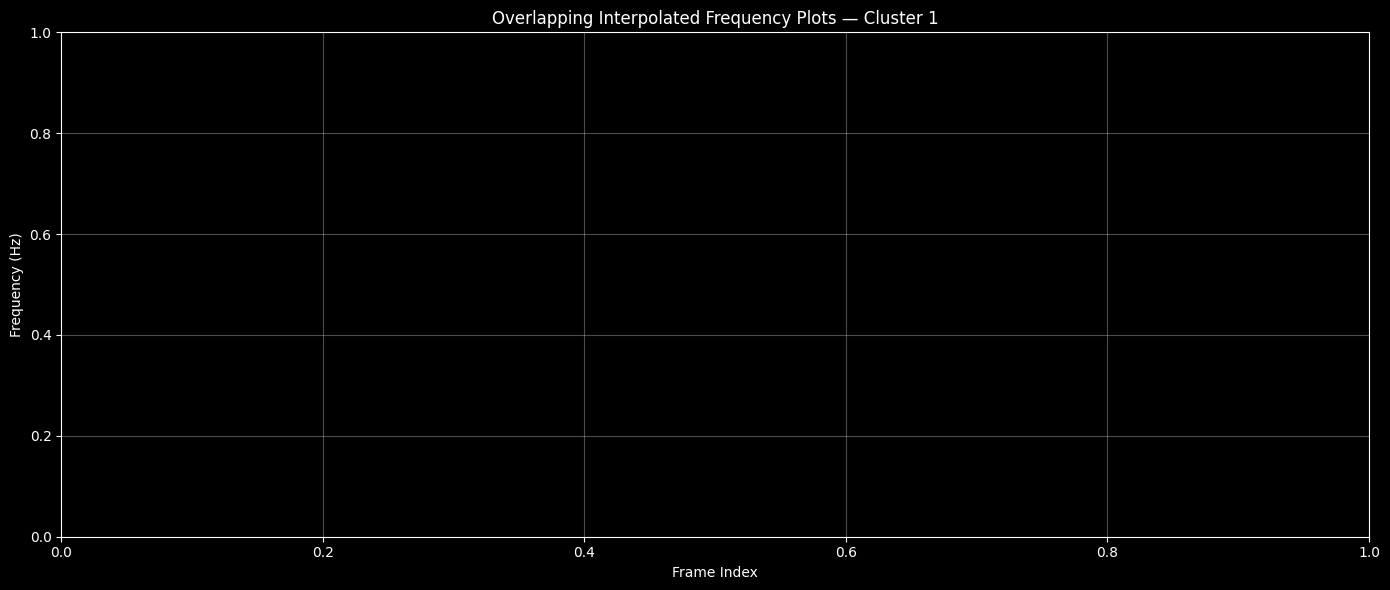


🎧 Playing Cluster 1 ===

📄 AudioPath: Vocals_file//Mayamalavagowlai\Mayamalavagowlai_DevadevaKalayami01__G#3.wav
🎵 Swara: Not labeled
⚠️ Could not load audio: zero-size array to reduction operation maximum which has no identity

📄 AudioPath: Vocals_file//Mayamalavagowlai\Mayamalavagowlai_DevadevaKalayami01__G#3.wav
🎵 Swara: Not labeled
⚠️ Could not load audio: zero-size array to reduction operation maximum which has no identity

📄 AudioPath: Vocals_file//Mayamalavagowlai\Mayamalavagowlai_DevadevaKalayami01__G#3.wav
🎵 Swara: Not labeled
⚠️ Could not load audio: zero-size array to reduction operation maximum which has no identity

📄 AudioPath: Vocals_file//Mayamalavagowlai\Mayamalavagowlai_DevadevaKalayami01__G#3.wav
🎵 Swara: Not labeled


KeyboardInterrupt: 

In [19]:
import pandas as pd
import librosa
import IPython.display as ipd

def play_second_phase_clusters(
    carva_csv: str,
    master_csv: str,
    sr: int = 44100
):
    """
    Play back motifs grouped by second-phase clustering from your carva CSV.
    Uses StartFrame/EndFrame and Index to map back to real audio.

    Args:
        carva_csv: Path to carva CSV with 'Index', 'AudioPath', 'StartFrame', 'EndFrame', 'Second Labels'.
        master_csv: Path to Master CSV with Time column.
        sr: Desired sampling rate for playback.
    """

    # Load data
    carva_df = pd.read_csv(carva_csv)
    master_df = pd.read_csv(master_csv)

    # Find unique clusters
    clusters = sorted(carva_df['Second Labels'].dropna().unique())

    for cluster_id in clusters:
        print(f"\n=== Playing Cluster {cluster_id} ===")
        cluster_rows = carva_df[carva_df['Second Labels'] == cluster_id]

        for _, row in cluster_rows.iterrows():
            audio_path = row['AudioPath']
            index = row['Index']
            start_idx = int(row['StartFrame'])
            end_idx = int(row['EndFrame'])

            # Get real time from Master CSV for this song
            spec_time = master_df[master_df['Index'] == index]['Time'].values

            # Protect against index overflow
            start_time = spec_time[start_idx] if start_idx < len(spec_time) else 0
            end_time = spec_time[end_idx] if end_idx < len(spec_time) else spec_time[-1]

            # Load audio
            audio, _ = librosa.load(audio_path, sr=sr)

            start_sample = int(start_time * sr)
            end_sample = int(end_time * sr)

            display(ipd.Audio(audio[start_sample:end_sample], rate=sr))

        print("-----------------------------")


import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import ast
import re
from scipy.signal import find_peaks

def clean_np_float_list(seg_str):
    """
    Convert a stringified list with np.float64(...) entries into a proper list of floats.
    """
    cleaned = re.sub(r'np\.float64\(([^)]+)\)', r'\1', seg_str)
    return np.array(ast.literal_eval(cleaned), dtype=float)

def play_specific_second_phase_cluster(
    carva_csv: str,
    master_csv: str,
    cluster_number: int,
    carnatic_frequencies: dict,
    sr: int = 44100
):
    """
    Plot interpolated frequency segments (overlapping from x=0) of a specific cluster, 
    showing extrema (peaks & valleys), then play the audio segments.
    """
    carva_df = pd.read_csv(carva_csv)
    master_df = pd.read_csv(master_csv)

    cluster_rows = carva_df[carva_df['Second Labels'] == cluster_number]

    if cluster_rows.empty:
        print(f"⚠️ No entries found for cluster {cluster_number}")
        return

    print(f"\n🎼 Plotting interpolated segments (overlapping) for Cluster {cluster_number}...")

    # Plot setup
    plt.style.use('dark_background')
    plt.figure(figsize=(14, 6))

    bars = list(carnatic_frequencies.values())
    all_freqs = []

    for _, row in cluster_rows.iterrows():
        seg_str = row.get('Interpolated_SegmentList', None)
        if pd.isna(seg_str):
            continue
        try:
            segment = clean_np_float_list(seg_str)
            x = np.arange(len(segment))
            plt.plot(x, segment, alpha=0.6, linewidth=1)

            # Plot extrema
            peaks, _ = find_peaks(segment)
            valleys, _ = find_peaks(-segment)
            plt.plot(x[peaks], segment[peaks], "o", color="cyan", markersize=4)
            plt.plot(x[valleys], segment[valleys], "o", color="cyan", markersize=4)

            all_freqs.extend(segment)
        except Exception as e:
            print(f"Skipping segment due to error: {e}")
            continue

    # Carnatic swara bars
    if all_freqs:
        min_freq = np.min(all_freqs)
        max_freq = np.max(all_freqs)
        newbars = [i for i in bars if min_freq <= i <= max_freq]

        for freq in newbars:
            note = get_closest_note(freq, carnatic_frequencies)
            plt.axhline(y=freq, color='orange', linestyle='--', linewidth=0.8)
            plt.text(0, freq, note, color='orange', fontsize=9, verticalalignment='bottom')

    plt.title(f"Overlapping Interpolated Frequency Plots — Cluster {cluster_number}")
    plt.xlabel("Frame Index")
    plt.ylabel("Frequency (Hz)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Playback
    print(f"\n🎧 Playing Cluster {cluster_number} ===")
    for _, row in cluster_rows.iterrows():
        audio_path = row['AudioPath']
        index = row['Index']
        start_idx = int(row['StartFrame'])
        end_idx = int(row['EndFrame'])
        swara = row['Swara'] if 'Swara' in row and pd.notna(row['Swara']) else "Not labeled"

        print(f"\n📄 AudioPath: {audio_path}")
        print(f"🎵 Swara: {swara}")

        spec_time = master_df[master_df['Index'] == index]['Time'].values
        start_time = spec_time[start_idx] if start_idx < len(spec_time) else 0
        end_time   = spec_time[end_idx] if end_idx < len(spec_time) else spec_time[-1]

        try:
            audio, _ = librosa.load(audio_path, sr=sr)
            start_sample = int(start_time * sr)
            end_sample = int(end_time * sr)
            display(ipd.Audio(audio[start_sample:end_sample], rate=sr))
        except Exception as e:
            print(f"⚠️ Could not load audio: {e}")

    print("\n-----------------------------")




carnatic_ratios = {
    'sa': 0.5*1.0,    # Tonic (Sa)
    'ri1': 0.5*16/15, # Ri1
    'ri2': 0.5*9/8,  # Ri2
    'ga1': 0.5*6/5,  # Ga1
    'ga2': 0.5*5/4, # Ga2
    'ma1': 0.5*4/3, # Ma1
    'ma2': 0.5*45/32,   # Ma2
    'pa': 0.5*3/2,    # Pa
    'da1': 0.5*8/5, # Dha1
    'da2': 0.5*5/3, # Dha2
    'ni1': 0.5*16/9, # Ni1
    'ni2': 0.5*15/8,   # Ni2

    'Sa': 1.0,    # Tonic (Sa)
    'Ri1': 16/15, # Ri1
    'Ri2': 9/8,  # Ri2
    'Ga1': 6/5,  # Ga1
    'Ga2': 5/4, # Ga2
    'Ma1': 4/3, # Ma1
    'Ma2': 45/32,   # Ma2
    'Pa': 3/2,    # Pa
    'Da1': 8/5, # Dha1
    'Da2': 5/3, # Dha2
    'Ni1': 16/9, # Ni1
    'Ni2': 15/8,   # Ni2

    'SA': 2.0,   # Octave higher (Sa)
    'RI1': 2*16/15, # Ri1
    'RI2': 2*9/8,  # Ri2
    'GA1': 2*6/5,  # Ga1
    'GA2': 2*5/4, # Ga2
    'MA1': 2*4/3, # Ma1
    'MA2': 2*45/32,   # Ma2
    'PA': 2*3/2,    # Pa
    'DA1': 2*8/5, # Dha1
    'DA2': 2*5/3, # Dha2
    'NI1': 2*16/9, # Ni1
    'NI2': 2*15/8,   
}

play_specific_second_phase_cluster(
    carnatic_frequencies=carnatic_ratios,
    carva_csv="carva_Mayamalavagowlai.csv",
    master_csv="Master_Crepe_Mayamalavagowlai.csv",
    cluster_number=1,
    sr=44100
)


In [ ]:
def label_swara_for_cluster(
    carva_csv: str,
    cluster_number: int,
    swara_label: str
):
    """
    Adds or updates a column 'Swara' in the carva CSV file.
    For all rows where 'Second Labels' == cluster_number, the value is set to swara_label.

    Args:
        carva_csv: Path to the carva CSV.
        cluster_number: The cluster number to label.
        swara_label: The string label to assign (e.g., 'S', 'R2', 'G3').
    """
    df = pd.read_csv(carva_csv)

    # Create the 'Swara' column if it doesn't exist
    if 'Swara' not in df.columns:
        df['Swara'] = ""

    # Apply the swara label to matching cluster rows
    match_count = (df['Second Labels'] == cluster_number).sum()
    if match_count == 0:
        print(f"⚠️ No rows found for cluster {cluster_number}. Nothing updated.")
    else:
        df.loc[df['Second Labels'] == cluster_number, 'Swara'] = swara_label
        df.to_csv(carva_csv, index=False)
        print(f"✅ Labeled {match_count} rows in cluster {cluster_number} as '{swara_label}'.")


label_swara_for_cluster(
    carva_csv="carva_Mayamalavagowlai.csv",
    cluster_number=14,   # The cluster you want to label
    swara_label="Ni2 Da1 Pa"    # The swara label to apply
)



✅ Labeled 3 rows in cluster 14 as 'Ni2 Da1 Pa'.
